**Time Series Forecasting with LSTM**

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
#from scipy import stats
#%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM
from tensorflow.keras.initializers import GlorotUniform
#from scipy.ndimage import gaussian_filter1d
#from scipy.signal import medfilt
from numpy.random import seed
np.random.seed(17)
#import tensorflow
#tensorflow.random.set_seed(1)
from numpy import array
import tensorflow as tf
import torch
tf.random.set_seed(17)
print("All libraries have been imported")

All libraries have been imported


> Version of Libraries

In [ ]:
print('Version of pandas    :', pd.__version__)
print('Version of numpy     :', np.__version__)
print('Version of matplotlib:', matplotlib.__version__)
print('Version of sklearn   :', sklearn.__version__)
print('Version of keras     :', keras.__version__)
print('Version of tensorflow:', tf.__version__)
print('Version of torch     :', torch.__version__)


Version of pandas    : 1.1.5
Version of numpy     : 1.19.5
Version of matplotlib: 3.2.2
Version of sklearn   : 0.22.2.post1
Version of keras     : 2.4.3
Version of tensorflow: 2.4.0
Version of torch     : 1.7.0+cu101


> Check GPU Device

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# The Data

> There are minimum temperature values between 01.01.2017 and 30.04.2017 for city of [Giresun](https://www.google.com/maps/place/Giresun,+Giresun+Merkez%2FGiresun/@40.9042433,38.309194,12z/data=!3m1!4b1!4m5!3m4!1s0x40636c6b991a79b7:0x2409f2df5be31b5f!8m2!3d40.917532!4d38.392653) in Turkey.

In [ ]:
df = pd.read_excel('temp2017min.xlsx')
df.head(10)

,Date,Min
0,2017-01-01,7.658333
1,2017-01-02,5.745833
2,2017-01-03,6.304167
3,2017-01-04,7.087500
4,2017-01-05,12.120833
5,2017-01-06,16.266667
6,2017-01-07,14.808333
7,2017-01-08,3.654167
8,2017-01-09,3.729167
9,2017-01-10,5.145833


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    120 non-null    datetime64[ns]
 1   Min     120 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.0 KB


In [ ]:
df.describe()

,Min
count,120.000000
mean,7.997674
std,3.730323
min,-0.683333
25%,6.069792
50%,8.285417
75%,9.998958
max,16.266667


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df_chg = df.set_index(['Date'], drop=True)
df_chg.head()

,Min
Date,
2017-01-01,7.658333
2017-01-02,5.745833
2017-01-03,6.304167
2017-01-04,7.087500
2017-01-05,12.120833


# Plotting The Data

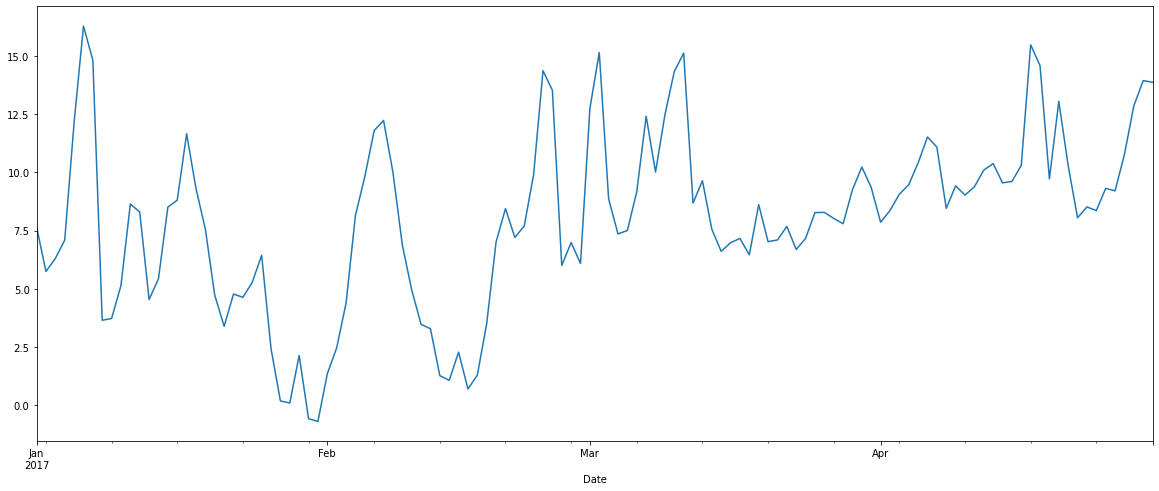

In [ ]:
plt.figure(figsize=(20,8),)
df_chg['Min'].plot();

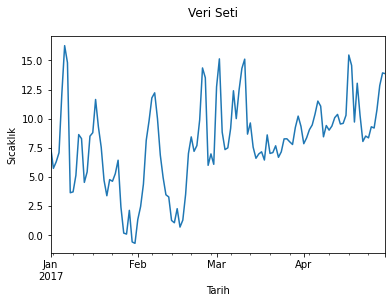

In [ ]:
fig = plt.figure()
df_chg['Min'].plot()
fig.suptitle('Veri Seti')
plt.xlabel('Tarih')
plt.ylabel('Sıcaklık')
plt.savefig('dataset.jpeg', dpi=300, quality=100, bbox_inches='tight')

# Split The Data

Split the data to train and test set by date "2017-04-17". That is, the data prior to this date is the traning data and the data from this data onward is the test data and we plotting it again.

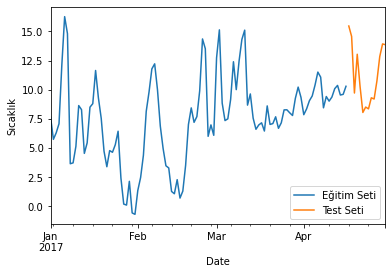

In [ ]:
split_date_train = pd.Timestamp('2017-04-16')
split_date_test = pd.Timestamp('2017-04-17')
df1 = df_chg['Min']
train_min = df1.loc[:split_date_train]
test_min = df1.loc[split_date_test:]
plt.figure()
plt.xlabel('Tarih')
plt.ylabel('Sıcaklık')
ax = train_min.plot()
test_min.plot(ax=ax)
plt.legend(['Eğitim Seti', 'Test Seti']);
plt.savefig('train_test.jpeg', dpi=300, quality=100, bbox_inches='tight')

In [ ]:
print('Number of training values: {:,}\n'.format(train_min.shape[0]))
print('Number of test values: {:,}\n'.format(test_min.shape[0]))

Number of training values: 106

Number of test values: 14



> Split train and test again for scale

In [ ]:
train_min_processed = df_chg.iloc[:, 0:1].values
train_min_processed = train_min_processed[0:106:1]
test_min_processed = df_chg.iloc[:, 0:1].values
test_min_processed = test_min_processed[106:120:1]

# Scale The Data

In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))
train_min_sc = scaler.fit_transform(train_min_processed)
test_min_sc = scaler.fit_transform(test_min_processed)

# LSTM - Traning Model

> We use shift function that shifts the entire column by 1.

In [ ]:
train_min_sc_df = pd.DataFrame(train_min_sc, columns=['Y'], index=train_min.index)

for s in range(1,2):
  train_min_sc_df['X_{}'.format(s)] = train_min_sc_df['Y'].shift(s)
  
X_train_min = train_min_sc_df.dropna().drop('Y', axis=1)
y_train_min = train_min_sc_df.dropna().drop('X_1', axis=1)

X_train_min = X_train_min['X_1']
y_train_min = y_train_min['Y']

X_train_min = X_train_min.values
y_train_min = y_train_min.values

> We will need to convert all our input variables in a 3D vector form.

In [ ]:
X_train_min_3d = X_train_min.reshape(X_train_min.shape[0], 1, 1)
X_test_min_3d = test_min_sc.reshape(test_min_sc.shape[0], 1, 1)

print('Train(Min) Shape:', X_train_min_3d.shape)
print('Test(Min) Shape:', X_test_min_3d.shape)

Train(Min) Shape: (105, 1, 1)
Test(Min) Shape: (14, 1, 1)


> LSTM



*   LSTM has a visible layer with 1 input.
*   A hidden layer with LSTM neurons.
*   We used relu activation function for the LSTM neurons.
*   A loss function is mean_squared_error , and An optimizer is adam.
*   Stop training when a monitored loss has stopped improving.
*   The LSTM is trained for 100 epoch and a batch size of 1 is used.

In [ ]:
lstm_model = Sequential()
initializer = GlorotUniform(seed=17)
lstm_model.add(LSTM(7, input_shape=(1, X_train_min_3d.shape[1]), activation='relu', kernel_initializer=initializer, return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=4, verbose=1, restore_best_weights=True, min_delta=0.0001)
history_lstm_model = lstm_model.fit(X_train_min_3d, y_train_min, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
105/105 [==============================] - 1s 2ms/step - loss: 0.2220
Epoch 2/100
105/105 [==============================] - 0s 2ms/step - loss: 0.2089
Epoch 3/100
105/105 [==============================] - 0s 2ms/step - loss: 0.1970
Epoch 4/100
105/105 [==============================] - 0s 2ms/step - loss: 0.1848
Epoch 5/100
105/105 [==============================] - 0s 2ms/step - loss: 0.1722
Epoch 6/100
105/105 [==============================] - 0s 2ms/step - loss: 0.1593
Epoch 7/100
105/105 [==============================] - 0s 2ms/step - loss: 0.1467
Epoch 8/100
105/105 [==============================] - 0s 2ms/step - loss: 0.1351
Epoch 9/100
105/105 [==============================] - 0s 2ms/step - loss: 0.1249
Epoch 10/100
105/105 [==============================] - 0s 2ms/step - loss: 0.1167
Epoch 11/100
105/105 [==============================] - 0s 2ms/step - loss: 0.1106
Epoch 12/100
105/105 [==============================] - 0s 2ms/step - loss: 0.1063
Epoch 13/100


In [ ]:
lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 7)                 252       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 8         
Total params: 260
Trainable params: 260
Non-trainable params: 0
_________________________________________________________________


In [ ]:
loss = history_lstm_model.history['loss']
epochs = range(len(loss))

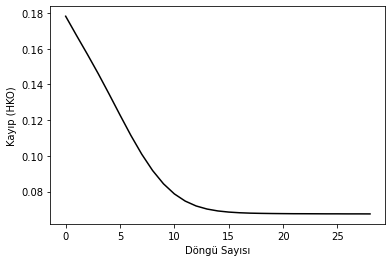

In [ ]:
plt.subplot()
plt.plot(epochs, loss, color='black')
plt.ylabel("Kayıp (HKO)")
plt.xlabel("Döngü Sayısı")
plt.savefig('epoch.jpeg', dpi=300, quality=100, bbox_inches='tight')

> We predict our LSTM model

In [ ]:
y_pred_train_min_lstm = lstm_model.predict(X_train_min_3d)
y_pred_test_min_lstm = lstm_model.predict(X_test_min_3d)

# Forecasting

De-normalize data

In [ ]:
y_pred_test_min_lstm_new = scaler.inverse_transform(y_pred_test_min_lstm)

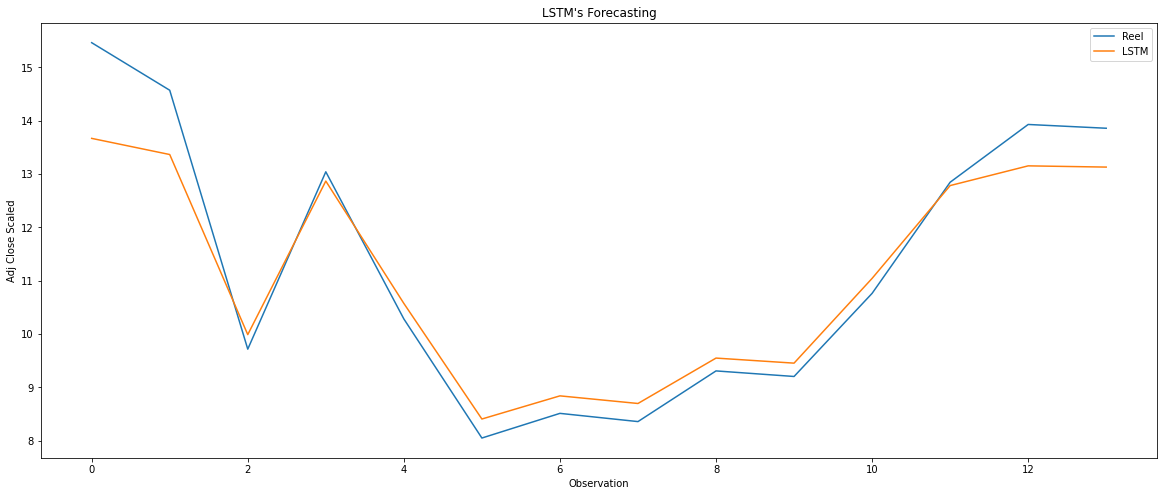

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(test_min_processed, label='Reel')
plt.plot(y_pred_test_min_lstm_new, label='LSTM')
plt.title("LSTM's Forecasting")
plt.xlabel('Observation')
plt.ylabel('Adj Close Scaled')
plt.legend()
plt.show();

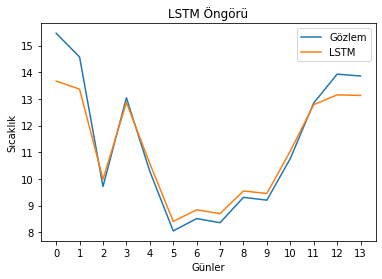

In [ ]:
plt.figure()
plt.plot(test_min_processed, label='Gözlem')
plt.plot(y_pred_test_min_lstm_new, label='LSTM')
plt.title("LSTM Öngörü")
plt.xlabel('Günler')
plt.ylabel('Sıcaklık')
plt.legend()
x = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
plt.xticks(x)
plt.savefig('pred.jpeg', dpi=300, quality=100, bbox_inches='tight')
plt.show();

Metrics

In [ ]:
MAE = metrics.mean_absolute_error(test_min_processed, y_pred_test_min_lstm_new)
MSE = metrics.mean_squared_error(test_min_processed, y_pred_test_min_lstm_new)
RMSE = np.sqrt(MSE)
R2 = metrics.r2_score(test_min_processed, y_pred_test_min_lstm_new)

print("Results of sklearn.metrics:")
print("MAE:", MAE)
print("MSE:", MSE)
print("RMSE:", RMSE)
print("R-Squared:", R2)

Results of sklearn.metrics:
MAE: 0.5070214407784602
MSE: 0.46756510729132034
RMSE: 0.6837873260680695
R-Squared: 0.9239500735798327


In [ ]:
y_pred_test_min_lstm_new

array([[13.668435],
       [13.365594],
       [ 9.989061],
       [12.867881],
       [10.57398 ],
       [ 8.406588],
       [ 8.840666],
       [ 8.697766],
       [ 9.548928],
       [ 9.454213],
       [11.043236],
       [12.78353 ],
       [13.153172],
       [13.130027]], dtype=float32)